# LSTM - vanilla

In [1]:
best_model = "best_model2.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


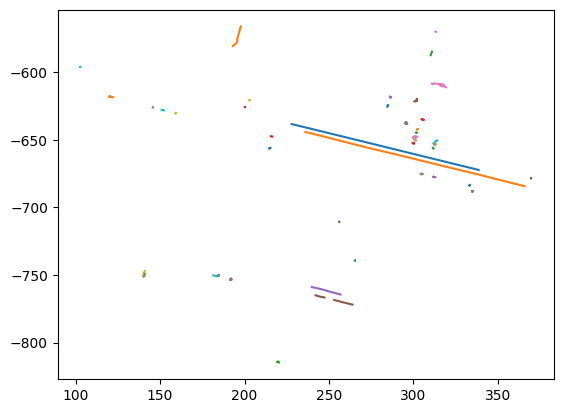

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [7]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [8]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [9]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :4]
        x = x.reshape(-1, 50, 50, 4)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [10]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [24]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=4, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr=0.007, => 8.12 final val, public score 9.118
        # lr = 0.01 => 7.9 final val, public score: 9.119
        # lr = 0.015, # => 8.0 final val, 9.0 public
        lr = 0.02, # => 10.5 final val, 11optional4
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [25]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_28946/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_28946/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:07<12:36,  7.64s/epoch]

Epoch 000 | LR 0.019000 | Train MSE 5.7600 | Val MSE 1.0906 | Val MAE 4.6677 | Val MSE 53.4393
Sample pred first 3 steps: [[-0.00544634 -0.01472018]
 [-0.02466344  0.05264921]
 [-0.06550986  0.04033234]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 1.090598


Epoch:   2%|▏         | 2/100 [00:15<12:15,  7.50s/epoch]

Epoch 001 | LR 0.018050 | Train MSE 0.7823 | Val MSE 0.3805 | Val MAE 2.5916 | Val MSE 18.6453
Validation improved: 1.090598 -> 0.380516


Epoch:   3%|▎         | 3/100 [00:22<11:59,  7.42s/epoch]

Epoch 002 | LR 0.017147 | Train MSE 0.7186 | Val MSE 0.4095 | Val MAE 2.5721 | Val MSE 20.0653


Epoch:   4%|▍         | 4/100 [00:30<12:14,  7.66s/epoch]

Epoch 003 | LR 0.016290 | Train MSE 0.7246 | Val MSE 0.3944 | Val MAE 2.6576 | Val MSE 19.3268


Epoch:   5%|▌         | 5/100 [00:38<12:15,  7.74s/epoch]

Epoch 004 | LR 0.015476 | Train MSE 0.6798 | Val MSE 0.3489 | Val MAE 2.2848 | Val MSE 17.0945
Validation improved: 0.380516 -> 0.348868


Epoch:   6%|▌         | 6/100 [00:46<12:15,  7.82s/epoch]

Epoch 005 | LR 0.014702 | Train MSE 0.6321 | Val MSE 0.4544 | Val MAE 2.8019 | Val MSE 22.2643
Sample pred first 3 steps: [[ 0.0065948  -0.0097685 ]
 [ 0.01755138 -0.00114881]
 [ 0.0348797   0.00385307]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [00:54<12:06,  7.81s/epoch]

Epoch 006 | LR 0.013967 | Train MSE 0.6282 | Val MSE 0.5631 | Val MAE 3.4067 | Val MSE 27.5924


Epoch:   8%|▊         | 8/100 [01:01<11:59,  7.82s/epoch]

Epoch 007 | LR 0.013268 | Train MSE 0.6174 | Val MSE 0.4141 | Val MAE 2.6009 | Val MSE 20.2889


Epoch:   9%|▉         | 9/100 [01:09<11:41,  7.70s/epoch]

Epoch 008 | LR 0.012605 | Train MSE 0.5963 | Val MSE 0.2978 | Val MAE 2.0927 | Val MSE 14.5919
Validation improved: 0.348868 -> 0.297794


Epoch:  10%|█         | 10/100 [01:16<11:28,  7.65s/epoch]

Epoch 009 | LR 0.011975 | Train MSE 0.5965 | Val MSE 0.4445 | Val MAE 2.7287 | Val MSE 21.7782


Epoch:  11%|█         | 11/100 [01:24<11:16,  7.60s/epoch]

Epoch 010 | LR 0.011376 | Train MSE 0.5745 | Val MSE 0.3770 | Val MAE 2.3975 | Val MSE 18.4713
Sample pred first 3 steps: [[-8.0739614e-05  6.9148177e-03]
 [ 3.9556264e-03 -4.3984898e-03]
 [ 1.6222571e-03 -9.4753690e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  12%|█▏        | 12/100 [01:31<11:04,  7.55s/epoch]

Epoch 011 | LR 0.010807 | Train MSE 0.5616 | Val MSE 0.3216 | Val MAE 2.2007 | Val MSE 15.7568


Epoch:  13%|█▎        | 13/100 [01:39<10:57,  7.56s/epoch]

Epoch 012 | LR 0.010267 | Train MSE 0.5614 | Val MSE 0.3471 | Val MAE 2.2562 | Val MSE 17.0089


Epoch:  14%|█▍        | 14/100 [01:47<10:52,  7.59s/epoch]

Epoch 013 | LR 0.009753 | Train MSE 0.5740 | Val MSE 0.3834 | Val MAE 2.5364 | Val MSE 18.7873


Epoch:  15%|█▌        | 15/100 [01:54<10:50,  7.66s/epoch]

Epoch 014 | LR 0.009266 | Train MSE 0.5754 | Val MSE 0.3135 | Val MAE 2.1257 | Val MSE 15.3633


Epoch:  16%|█▌        | 16/100 [02:02<10:42,  7.65s/epoch]

Epoch 015 | LR 0.008803 | Train MSE 0.5527 | Val MSE 0.2834 | Val MAE 1.9746 | Val MSE 13.8862
Sample pred first 3 steps: [[-0.00073911  0.00176984]
 [-0.00332992  0.00322542]
 [ 0.00211967  0.00855912]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.297794 -> 0.283393


Epoch:  17%|█▋        | 17/100 [02:10<10:46,  7.79s/epoch]

Epoch 016 | LR 0.008362 | Train MSE 0.5596 | Val MSE 0.3023 | Val MAE 2.0794 | Val MSE 14.8106


Epoch:  18%|█▊        | 18/100 [02:18<10:49,  7.92s/epoch]

Epoch 017 | LR 0.007944 | Train MSE 0.5482 | Val MSE 0.3095 | Val MAE 2.1969 | Val MSE 15.1648


Epoch:  19%|█▉        | 19/100 [02:26<10:37,  7.87s/epoch]

Epoch 018 | LR 0.007547 | Train MSE 0.5437 | Val MSE 0.3003 | Val MAE 2.1277 | Val MSE 14.7165


Epoch:  20%|██        | 20/100 [02:34<10:23,  7.79s/epoch]

Epoch 019 | LR 0.007170 | Train MSE 0.5431 | Val MSE 0.2776 | Val MAE 1.9947 | Val MSE 13.6023
Validation improved: 0.283393 -> 0.277599


Epoch:  21%|██        | 21/100 [02:42<10:20,  7.86s/epoch]

Epoch 020 | LR 0.006811 | Train MSE 0.5215 | Val MSE 0.3492 | Val MAE 2.3590 | Val MSE 17.1092
Sample pred first 3 steps: [[-0.00265392 -0.00274003]
 [-0.00228084 -0.00123165]
 [-0.0039669  -0.01489578]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [02:49<10:06,  7.78s/epoch]

Epoch 021 | LR 0.006471 | Train MSE 0.5439 | Val MSE 0.2857 | Val MAE 2.0973 | Val MSE 14.0005


Epoch:  23%|██▎       | 23/100 [02:57<09:57,  7.76s/epoch]

Epoch 022 | LR 0.006147 | Train MSE 0.5179 | Val MSE 0.3047 | Val MAE 2.1899 | Val MSE 14.9322


Epoch:  24%|██▍       | 24/100 [03:04<09:40,  7.64s/epoch]

Epoch 023 | LR 0.005840 | Train MSE 0.5362 | Val MSE 0.2917 | Val MAE 2.1569 | Val MSE 14.2951


Epoch:  25%|██▌       | 25/100 [03:12<09:33,  7.65s/epoch]

Epoch 024 | LR 0.005548 | Train MSE 0.5325 | Val MSE 0.3004 | Val MAE 2.1366 | Val MSE 14.7213


Epoch:  26%|██▌       | 26/100 [03:20<09:25,  7.64s/epoch]

Epoch 025 | LR 0.005270 | Train MSE 0.5277 | Val MSE 0.3156 | Val MAE 2.2563 | Val MSE 15.4632
Sample pred first 3 steps: [[-0.00619776  0.00155567]
 [-0.01648824 -0.000933  ]
 [-0.02938575 -0.01060029]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [03:27<09:19,  7.67s/epoch]

Epoch 026 | LR 0.005007 | Train MSE 0.4987 | Val MSE 0.2828 | Val MAE 1.9389 | Val MSE 13.8575


Epoch:  28%|██▊       | 28/100 [03:35<09:05,  7.57s/epoch]

Epoch 027 | LR 0.004757 | Train MSE 0.5092 | Val MSE 0.2550 | Val MAE 1.8805 | Val MSE 12.4940
Validation improved: 0.277599 -> 0.254979


Epoch:  29%|██▉       | 29/100 [03:43<09:06,  7.69s/epoch]

Epoch 028 | LR 0.004519 | Train MSE 0.4769 | Val MSE 0.2823 | Val MAE 1.9555 | Val MSE 13.8305


Epoch:  30%|███       | 30/100 [03:50<08:55,  7.66s/epoch]

Epoch 029 | LR 0.004293 | Train MSE 0.4936 | Val MSE 0.2936 | Val MAE 2.1301 | Val MSE 14.3860


Epoch:  31%|███       | 31/100 [03:58<08:52,  7.72s/epoch]

Epoch 030 | LR 0.004078 | Train MSE 0.5015 | Val MSE 0.2701 | Val MAE 1.9531 | Val MSE 13.2361
Sample pred first 3 steps: [[ 0.00171031 -0.00096225]
 [-0.00375198  0.00708183]
 [ 0.00249969  0.01221419]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [04:06<08:41,  7.67s/epoch]

Epoch 031 | LR 0.003874 | Train MSE 0.5085 | Val MSE 0.3103 | Val MAE 2.1975 | Val MSE 15.2065


Epoch:  33%|███▎      | 33/100 [04:13<08:35,  7.70s/epoch]

Epoch 032 | LR 0.003681 | Train MSE 0.4886 | Val MSE 0.3026 | Val MAE 2.1369 | Val MSE 14.8281


Epoch:  34%|███▍      | 34/100 [04:21<08:21,  7.61s/epoch]

Epoch 033 | LR 0.003496 | Train MSE 0.4932 | Val MSE 0.2512 | Val MAE 1.7773 | Val MSE 12.3064
Validation improved: 0.254979 -> 0.251150


Epoch:  35%|███▌      | 35/100 [04:30<08:36,  7.95s/epoch]

Epoch 034 | LR 0.003322 | Train MSE 0.4819 | Val MSE 0.2852 | Val MAE 2.0614 | Val MSE 13.9724


Epoch:  36%|███▌      | 36/100 [04:38<08:29,  7.96s/epoch]

Epoch 035 | LR 0.003156 | Train MSE 0.4891 | Val MSE 0.2570 | Val MAE 1.8336 | Val MSE 12.5921
Sample pred first 3 steps: [[-0.00129631  0.00153388]
 [-0.0013018   0.00100037]
 [-0.00183062  0.00250034]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [04:45<08:18,  7.91s/epoch]

Epoch 036 | LR 0.002998 | Train MSE 0.4996 | Val MSE 0.2701 | Val MAE 1.9391 | Val MSE 13.2366


Epoch:  38%|███▊      | 38/100 [04:53<08:00,  7.75s/epoch]

Epoch 037 | LR 0.002848 | Train MSE 0.4787 | Val MSE 0.2534 | Val MAE 1.8311 | Val MSE 12.4189


Epoch:  39%|███▉      | 39/100 [05:00<07:48,  7.67s/epoch]

Epoch 038 | LR 0.002706 | Train MSE 0.4891 | Val MSE 0.2551 | Val MAE 1.9244 | Val MSE 12.5023


Epoch:  40%|████      | 40/100 [05:09<07:53,  7.89s/epoch]

Epoch 039 | LR 0.002570 | Train MSE 0.4696 | Val MSE 0.2775 | Val MAE 1.9480 | Val MSE 13.5969


Epoch:  41%|████      | 41/100 [05:16<07:43,  7.85s/epoch]

Epoch 040 | LR 0.002442 | Train MSE 0.4928 | Val MSE 0.2410 | Val MAE 1.7950 | Val MSE 11.8068
Sample pred first 3 steps: [[0.00154729 0.0009993 ]
 [0.00496507 0.0045645 ]
 [0.00901077 0.00691923]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.251150 -> 0.240956


Epoch:  42%|████▏     | 42/100 [05:24<07:25,  7.68s/epoch]

Epoch 041 | LR 0.002320 | Train MSE 0.4613 | Val MSE 0.2535 | Val MAE 1.8787 | Val MSE 12.4226


Epoch:  43%|████▎     | 43/100 [05:31<07:07,  7.50s/epoch]

Epoch 042 | LR 0.002204 | Train MSE 0.4771 | Val MSE 0.2566 | Val MAE 1.8507 | Val MSE 12.5735


Epoch:  44%|████▍     | 44/100 [05:38<06:56,  7.44s/epoch]

Epoch 043 | LR 0.002093 | Train MSE 0.4707 | Val MSE 0.2703 | Val MAE 2.0118 | Val MSE 13.2447


Epoch:  45%|████▌     | 45/100 [05:46<06:52,  7.49s/epoch]

Epoch 044 | LR 0.001989 | Train MSE 0.4684 | Val MSE 0.2426 | Val MAE 1.8000 | Val MSE 11.8856


Epoch:  46%|████▌     | 46/100 [05:53<06:41,  7.43s/epoch]

Epoch 045 | LR 0.001889 | Train MSE 0.4710 | Val MSE 0.2427 | Val MAE 1.8453 | Val MSE 11.8941
Sample pred first 3 steps: [[-0.0065433  -0.00055232]
 [-0.01005428  0.00143192]
 [-0.01764311  0.00135956]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [06:00<06:23,  7.24s/epoch]

Epoch 046 | LR 0.001795 | Train MSE 0.4756 | Val MSE 0.2560 | Val MAE 1.8681 | Val MSE 12.5432


Epoch:  48%|████▊     | 48/100 [06:06<06:03,  7.00s/epoch]

Epoch 047 | LR 0.001705 | Train MSE 0.4661 | Val MSE 0.2601 | Val MAE 1.9704 | Val MSE 12.7436


Epoch:  49%|████▉     | 49/100 [06:14<06:05,  7.18s/epoch]

Epoch 048 | LR 0.001620 | Train MSE 0.4794 | Val MSE 0.2399 | Val MAE 1.7280 | Val MSE 11.7545
Validation improved: 0.240956 -> 0.239887


Epoch:  50%|█████     | 50/100 [06:21<06:01,  7.23s/epoch]

Epoch 049 | LR 0.001539 | Train MSE 0.4580 | Val MSE 0.2331 | Val MAE 1.7268 | Val MSE 11.4219
Validation improved: 0.239887 -> 0.233101


Epoch:  51%|█████     | 51/100 [06:29<06:03,  7.42s/epoch]

Epoch 050 | LR 0.001462 | Train MSE 0.4699 | Val MSE 0.2336 | Val MAE 1.7456 | Val MSE 11.4466
Sample pred first 3 steps: [[-0.00387254  0.00291892]
 [-0.00546072  0.00853286]
 [-0.00764897  0.01270044]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [06:36<05:54,  7.39s/epoch]

Epoch 051 | LR 0.001389 | Train MSE 0.4616 | Val MSE 0.2565 | Val MAE 1.9330 | Val MSE 12.5704


Epoch:  53%|█████▎    | 53/100 [06:44<05:47,  7.39s/epoch]

Epoch 052 | LR 0.001319 | Train MSE 0.4571 | Val MSE 0.2386 | Val MAE 1.7282 | Val MSE 11.6906


Epoch:  54%|█████▍    | 54/100 [06:51<05:38,  7.36s/epoch]

Epoch 053 | LR 0.001253 | Train MSE 0.4665 | Val MSE 0.2393 | Val MAE 1.7364 | Val MSE 11.7239


Epoch:  55%|█████▌    | 55/100 [06:58<05:30,  7.35s/epoch]

Epoch 054 | LR 0.001191 | Train MSE 0.4570 | Val MSE 0.2415 | Val MAE 1.7512 | Val MSE 11.8336


Epoch:  56%|█████▌    | 56/100 [07:06<05:24,  7.37s/epoch]

Epoch 055 | LR 0.001131 | Train MSE 0.4551 | Val MSE 0.2426 | Val MAE 1.7285 | Val MSE 11.8872
Sample pred first 3 steps: [[-6.4066210e-04 -6.8815128e-04]
 [-2.1843691e-04 -1.8249522e-04]
 [-3.3531268e-04 -6.1357627e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  57%|█████▋    | 57/100 [07:13<05:16,  7.36s/epoch]

Epoch 056 | LR 0.001075 | Train MSE 0.4515 | Val MSE 0.2513 | Val MAE 1.8571 | Val MSE 12.3122


Epoch:  58%|█████▊    | 58/100 [07:21<05:12,  7.45s/epoch]

Epoch 057 | LR 0.001021 | Train MSE 0.4620 | Val MSE 0.2487 | Val MAE 1.8485 | Val MSE 12.1843


Epoch:  59%|█████▉    | 59/100 [07:28<05:07,  7.50s/epoch]

Epoch 058 | LR 0.000970 | Train MSE 0.4571 | Val MSE 0.2406 | Val MAE 1.7259 | Val MSE 11.7880


Epoch:  60%|██████    | 60/100 [07:36<05:03,  7.59s/epoch]

Epoch 059 | LR 0.000921 | Train MSE 0.4542 | Val MSE 0.2401 | Val MAE 1.7350 | Val MSE 11.7637


Epoch:  61%|██████    | 61/100 [07:44<04:58,  7.65s/epoch]

Epoch 060 | LR 0.000875 | Train MSE 0.4487 | Val MSE 0.2355 | Val MAE 1.7272 | Val MSE 11.5409
Sample pred first 3 steps: [[ 0.0014854  -0.00138476]
 [ 0.00231706 -0.00151993]
 [ 0.00282014 -0.00190255]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [07:52<04:50,  7.63s/epoch]

Epoch 061 | LR 0.000832 | Train MSE 0.4513 | Val MSE 0.2340 | Val MAE 1.7741 | Val MSE 11.4654


Epoch:  63%|██████▎   | 63/100 [07:59<04:38,  7.54s/epoch]

Epoch 062 | LR 0.000790 | Train MSE 0.4433 | Val MSE 0.2339 | Val MAE 1.7015 | Val MSE 11.4608


Epoch:  64%|██████▍   | 64/100 [08:06<04:28,  7.46s/epoch]

Epoch 063 | LR 0.000750 | Train MSE 0.4546 | Val MSE 0.2354 | Val MAE 1.7087 | Val MSE 11.5327


Epoch:  65%|██████▌   | 65/100 [08:13<04:17,  7.37s/epoch]

Epoch 064 | LR 0.000713 | Train MSE 0.4511 | Val MSE 0.2338 | Val MAE 1.7416 | Val MSE 11.4557


Epoch:  66%|██████▌   | 66/100 [08:21<04:10,  7.37s/epoch]

Epoch 065 | LR 0.000677 | Train MSE 0.4564 | Val MSE 0.2292 | Val MAE 1.7099 | Val MSE 11.2300
Sample pred first 3 steps: [[ 0.00183663 -0.0001685 ]
 [ 0.00331689 -0.0002303 ]
 [ 0.00582176  0.00053442]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.233101 -> 0.229184


Epoch:  67%|██████▋   | 67/100 [08:28<04:05,  7.44s/epoch]

Epoch 066 | LR 0.000643 | Train MSE 0.4390 | Val MSE 0.2385 | Val MAE 1.7238 | Val MSE 11.6845


Epoch:  68%|██████▊   | 68/100 [08:36<04:05,  7.66s/epoch]

Epoch 067 | LR 0.000611 | Train MSE 0.4479 | Val MSE 0.2338 | Val MAE 1.7208 | Val MSE 11.4583


Epoch:  69%|██████▉   | 69/100 [08:44<04:01,  7.78s/epoch]

Epoch 068 | LR 0.000581 | Train MSE 0.4535 | Val MSE 0.2239 | Val MAE 1.6667 | Val MSE 10.9697
Validation improved: 0.229184 -> 0.223872


Epoch:  70%|███████   | 70/100 [08:53<03:56,  7.90s/epoch]

Epoch 069 | LR 0.000552 | Train MSE 0.4494 | Val MSE 0.2339 | Val MAE 1.7112 | Val MSE 11.4609


Epoch:  71%|███████   | 71/100 [09:01<03:56,  8.15s/epoch]

Epoch 070 | LR 0.000524 | Train MSE 0.4367 | Val MSE 0.2388 | Val MAE 1.7535 | Val MSE 11.6998
Sample pred first 3 steps: [[-0.00207373  0.00069894]
 [-0.00383381  0.00078284]
 [-0.00553685  0.00090161]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [09:10<03:50,  8.24s/epoch]

Epoch 071 | LR 0.000498 | Train MSE 0.4464 | Val MSE 0.2266 | Val MAE 1.6770 | Val MSE 11.1031


Epoch:  73%|███████▎  | 73/100 [09:19<03:50,  8.52s/epoch]

Epoch 072 | LR 0.000473 | Train MSE 0.4484 | Val MSE 0.2355 | Val MAE 1.7111 | Val MSE 11.5419


Epoch:  74%|███████▍  | 74/100 [09:28<03:45,  8.67s/epoch]

Epoch 073 | LR 0.000449 | Train MSE 0.4425 | Val MSE 0.2292 | Val MAE 1.6892 | Val MSE 11.2330


Epoch:  75%|███████▌  | 75/100 [09:37<03:40,  8.82s/epoch]

Epoch 074 | LR 0.000427 | Train MSE 0.4502 | Val MSE 0.2282 | Val MAE 1.7202 | Val MSE 11.1812


Epoch:  76%|███████▌  | 76/100 [09:46<03:34,  8.93s/epoch]

Epoch 075 | LR 0.000406 | Train MSE 0.4412 | Val MSE 0.2242 | Val MAE 1.6834 | Val MSE 10.9836
Sample pred first 3 steps: [[-0.00181377  0.00068062]
 [-0.00266826  0.00112304]
 [-0.00323879  0.00142116]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [09:55<03:20,  8.73s/epoch]

Epoch 076 | LR 0.000385 | Train MSE 0.4575 | Val MSE 0.2235 | Val MAE 1.6645 | Val MSE 10.9508
Validation improved: 0.223872 -> 0.223486


Epoch:  78%|███████▊  | 78/100 [10:03<03:06,  8.49s/epoch]

Epoch 077 | LR 0.000366 | Train MSE 0.4466 | Val MSE 0.2263 | Val MAE 1.6775 | Val MSE 11.0892


Epoch:  79%|███████▉  | 79/100 [10:10<02:53,  8.24s/epoch]

Epoch 078 | LR 0.000348 | Train MSE 0.4403 | Val MSE 0.2303 | Val MAE 1.6887 | Val MSE 11.2853


Epoch:  80%|████████  | 80/100 [10:18<02:42,  8.14s/epoch]

Epoch 079 | LR 0.000330 | Train MSE 0.4585 | Val MSE 0.2250 | Val MAE 1.6667 | Val MSE 11.0236


Epoch:  81%|████████  | 81/100 [10:26<02:31,  7.96s/epoch]

Epoch 080 | LR 0.000314 | Train MSE 0.4450 | Val MSE 0.2310 | Val MAE 1.6945 | Val MSE 11.3201
Sample pred first 3 steps: [[ 3.5490451e-04 -5.7194068e-04]
 [ 2.6002171e-04 -8.4651093e-04]
 [ 4.0295366e-05 -7.4806268e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [10:33<02:18,  7.71s/epoch]

Epoch 081 | LR 0.000298 | Train MSE 0.4533 | Val MSE 0.2250 | Val MAE 1.6647 | Val MSE 11.0243


Epoch:  83%|████████▎ | 83/100 [10:41<02:11,  7.75s/epoch]

Epoch 082 | LR 0.000283 | Train MSE 0.4425 | Val MSE 0.2215 | Val MAE 1.6729 | Val MSE 10.8513
Validation improved: 0.223486 -> 0.221454


Epoch:  84%|████████▍ | 84/100 [10:48<02:04,  7.75s/epoch]

Epoch 083 | LR 0.000269 | Train MSE 0.4396 | Val MSE 0.2172 | Val MAE 1.6305 | Val MSE 10.6411
Validation improved: 0.221454 -> 0.217166


Epoch:  85%|████████▌ | 85/100 [10:56<01:53,  7.58s/epoch]

Epoch 084 | LR 0.000256 | Train MSE 0.4413 | Val MSE 0.2286 | Val MAE 1.6973 | Val MSE 11.2035


Epoch:  86%|████████▌ | 86/100 [11:03<01:44,  7.48s/epoch]

Epoch 085 | LR 0.000243 | Train MSE 0.4344 | Val MSE 0.2218 | Val MAE 1.6591 | Val MSE 10.8683
Sample pred first 3 steps: [[-0.00079412  0.0011244 ]
 [-0.00055661  0.00077316]
 [-0.00044486  0.00073554]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [11:10<01:37,  7.51s/epoch]

Epoch 086 | LR 0.000231 | Train MSE 0.4446 | Val MSE 0.2252 | Val MAE 1.7337 | Val MSE 11.0339


Epoch:  88%|████████▊ | 88/100 [11:18<01:30,  7.52s/epoch]

Epoch 087 | LR 0.000219 | Train MSE 0.4332 | Val MSE 0.2221 | Val MAE 1.6500 | Val MSE 10.8847


Epoch:  89%|████████▉ | 89/100 [11:26<01:23,  7.60s/epoch]

Epoch 088 | LR 0.000208 | Train MSE 0.4361 | Val MSE 0.2260 | Val MAE 1.6876 | Val MSE 11.0755


Epoch:  90%|█████████ | 90/100 [11:33<01:15,  7.58s/epoch]

Epoch 089 | LR 0.000198 | Train MSE 0.4391 | Val MSE 0.2181 | Val MAE 1.6399 | Val MSE 10.6888


Epoch:  91%|█████████ | 91/100 [11:41<01:08,  7.57s/epoch]

Epoch 090 | LR 0.000188 | Train MSE 0.4405 | Val MSE 0.2228 | Val MAE 1.6800 | Val MSE 10.9172
Sample pred first 3 steps: [[-0.0004157  -0.00086713]
 [-0.00085212 -0.00158472]
 [-0.0012627  -0.00203307]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [11:49<01:01,  7.68s/epoch]

Epoch 091 | LR 0.000178 | Train MSE 0.4419 | Val MSE 0.2166 | Val MAE 1.6627 | Val MSE 10.6132
Validation improved: 0.217166 -> 0.216596


Epoch:  93%|█████████▎| 93/100 [11:56<00:53,  7.63s/epoch]

Epoch 092 | LR 0.000170 | Train MSE 0.4296 | Val MSE 0.2207 | Val MAE 1.6625 | Val MSE 10.8147


Epoch:  94%|█████████▍| 94/100 [12:04<00:45,  7.51s/epoch]

Epoch 093 | LR 0.000161 | Train MSE 0.4307 | Val MSE 0.2159 | Val MAE 1.6342 | Val MSE 10.5781
Validation improved: 0.216596 -> 0.215881


Epoch:  95%|█████████▌| 95/100 [12:12<00:38,  7.66s/epoch]

Epoch 094 | LR 0.000153 | Train MSE 0.4431 | Val MSE 0.2183 | Val MAE 1.6754 | Val MSE 10.6970


Epoch:  96%|█████████▌| 96/100 [12:20<00:31,  7.76s/epoch]

Epoch 095 | LR 0.000145 | Train MSE 0.4414 | Val MSE 0.2171 | Val MAE 1.6492 | Val MSE 10.6364
Sample pred first 3 steps: [[-2.4019353e-04 -3.6009442e-05]
 [-2.9581430e-04 -1.9162151e-04]
 [-3.5004414e-04 -3.9133022e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [12:27<00:23,  7.74s/epoch]

Epoch 096 | LR 0.000138 | Train MSE 0.4262 | Val MSE 0.2199 | Val MAE 1.6668 | Val MSE 10.7744


Epoch:  98%|█████████▊| 98/100 [12:35<00:15,  7.63s/epoch]

Epoch 097 | LR 0.000131 | Train MSE 0.4450 | Val MSE 0.2144 | Val MAE 1.6335 | Val MSE 10.5075
Validation improved: 0.215881 -> 0.214438


Epoch:  99%|█████████▉| 99/100 [12:42<00:07,  7.63s/epoch]

Epoch 098 | LR 0.000125 | Train MSE 0.4245 | Val MSE 0.2205 | Val MAE 1.6667 | Val MSE 10.8034


Epoch: 100%|██████████| 100/100 [12:50<00:00,  7.70s/epoch]


Epoch 099 | LR 0.000118 | Train MSE 0.4328 | Val MSE 0.2165 | Val MAE 1.6472 | Val MSE 10.6101
Val MSE: 10.5075


SimpleLSTM(
  (lstm): LSTM(4, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

# Final Pred

In [26]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto11-optional4.csv', index=True)